# Around Simpson’s Paradox : Smoking and 20-year survival (Whickham study, women)

## Context

This notebook analyzes women from the 1972–1994 Whickham health survey to study how smoking affects 20-year survival, using three variables: Smoker (Yes/No), Status (Alive/Dead after 20 years), and Age at the first survey. The study highlights Simpson’s Paradox where data can misleadingly suggest smokers live longer, but the pattern changes when results are stratified by age. We will also fit a logistic regression to model death probability as a function of age and smoking.
- The dataset is stored locally in this repository as a CSV file (used for all computations)
- Data file: `Subject6_smoking.csv`
- The original context comes from the Whickham study publications (Tunbridge et al. 1977 / Vanderpump et al. 1995)

## Part A: Overall aggregated analysis
### 1) Load data and inspect structure
We load the data from the CSV file. We then review the data structure and check for any missing values to ensure the analysis is clean and reliable.

In [37]:
import pandas as pd
import numpy as np

DATA_PATH = "Subject6_smoking.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
df.info()

Shape: (1314, 3)


,Smoker,Status,Age
0,Yes,Alive,21.0
1,Yes,Alive,19.3
2,No,Dead,57.5
3,No,Alive,47.1
4,Yes,Alive,81.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Smoker  1314 non-null   object 
 1   Status  1314 non-null   object 
 2   Age     1314 non-null   float64
dtypes: float64(1), object(2)
memory usage: 30.9+ KB


In [38]:
df["Smoker"] = df["Smoker"].astype(str).str.strip().str.title()   # Yes/No
df["Status"] = df["Status"].astype(str).str.strip().str.title()   # Alive/Dead
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

print("Smoker categories:", df["Smoker"].unique())
print("Status categories:", df["Status"].unique())
print("Missing Age:", df["Age"].isna().sum())

Smoker categories: ['Yes' 'No']
Status categories: ['Alive' 'Dead']
Missing Age: 0


From the inspection, no missing values of data is recorded.

### 2) Overall table and mortality rate by smoking
The next step is to tabulate the total number of women alive and dead over the period according to their smoking habits and compute the mortality rate for smokers and non-smokers: **Mortality rate = the number of women who died in a group / the total number of women in that group**. We also add 95% CI for each mortality rate.

In [39]:
from statsmodels.stats.proportion import proportion_confint
table = pd.crosstab(df["Smoker"], df["Status"])

mortality = (table["Dead"] / table.sum(axis=1)).rename("mortality_rate")

result = table.join(mortality)
# result

ci = []
for group in result.index:
    dead = result.loc[group, "Dead"]
    n = result.loc[group, ["Alive", "Dead"]].sum()
    low, high = proportion_confint(dead, n, alpha=0.05, method="wilson")
    ci.append((low, high))

result["ci_low"] = [c[0] for c in ci]
result["ci_high"] = [c[1] for c in ci]
result

,Alive,Dead,mortality_rate,ci_low,ci_high
Smoker,,,,,
No,502,230,0.314208,0.281624,0.348731
Yes,443,139,0.238832,0.205976,0.275112


### 3) Visualization of the Mortality rate over 20 years

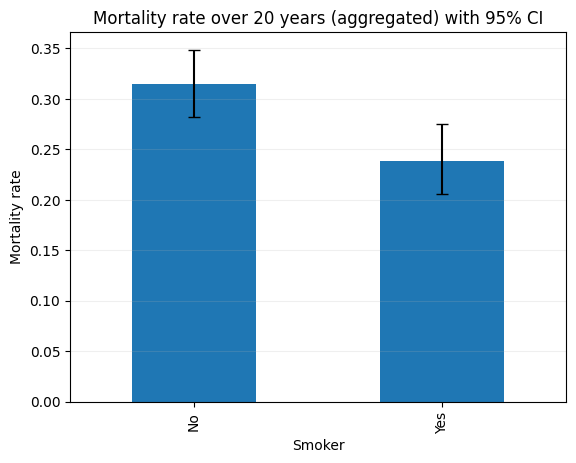

In [40]:
import matplotlib.pyplot as plt

ax = result["mortality_rate"].plot(kind="bar", yerr=(result["mortality_rate"]-result["ci_low"],
                                                    result["ci_high"]-result["mortality_rate"]),
                                   capsize=4)
ax.set_title("Mortality rate over 20 years (aggregated) with 95% CI")
ax.set_xlabel("Smoker")
ax.set_ylabel("Mortality rate")
ax.grid(True, axis="y", alpha=0.2)
plt.show()

In [27]:
# mortality.plot(kind="bar")
# plt.title("Mortality rate over 20 years (aggregated)")
# plt.xlabel("Smoker")
# plt.ylabel("Mortality rate")
# plt.grid(True, axis="y", alpha=0.2)
# plt.show()

The results show that over the 20-year period, **smokers have a lower mortality rate (23.9%) than non-smokers (31.4%)** and this is surprising because usually we expect smoking to increase mortality. This suggests that a likely confounding factor differs between the two groups, making the aggregated comparison misleading.

## Part B: Demonstrate the Simpson’s paradox with Age stratification
### 1) Create age groups
The overall mortality comparison can be misleading if the two groups (smokers vs non-smokers) do not have the same age distribution. Since mortality strongly increases with age, we add a new category related to the age group (18–34, 35–54, 55–64, 65+) and recompute mortality rates within each group.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bins = [18, 35, 55, 65, np.inf]
labels = ["18–34", "35–54", "55–64", "65+"]

df["age_group"] = pd.cut(df["Age"], bins=bins, right=False, labels=labels)

# Quick check
df["age_group"].value_counts().sort_index()

age_group
18–34    416
35–54    420
55–64    236
65+      242
Name: count, dtype: int64

### 2) Recompute tables within age groups and plot the results

In [29]:
counts = pd.crosstab([df["age_group"], df["Smoker"]], df["Status"])
counts = counts.reset_index()

counts["total"] = counts["Alive"] + counts["Dead"]
counts["mortality_rate"] = counts["Dead"] / counts["total"]

rates = counts[["age_group", "Smoker", "Alive", "Dead", "mortality_rate"]]
display(rates)

pivot_rates = rates.pivot(index="age_group", columns="Smoker", values="mortality_rate")
# display(pivot_rates)

Status,age_group,Smoker,Alive,Dead,mortality_rate
0,18–34,No,221,6,0.026432
1,18–34,Yes,182,7,0.037037
2,35–54,No,172,19,0.099476
3,35–54,Yes,190,39,0.170306
4,55–64,No,81,40,0.330579
5,55–64,Yes,64,51,0.443478
6,65+,No,28,165,0.854922
7,65+,Yes,7,42,0.857143


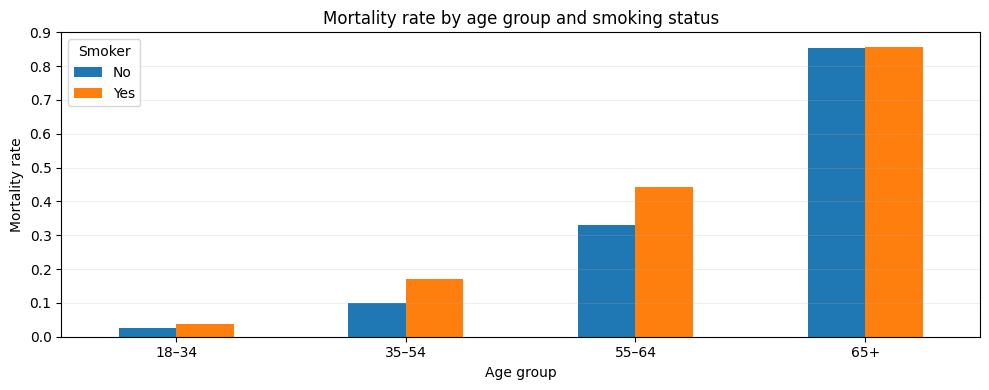

In [30]:
ax = pivot_rates.plot(kind="bar", figsize=(10,4))
ax.set_title("Mortality rate by age group and smoking status")
ax.set_xlabel("Age group")
ax.set_ylabel("Mortality rate")
ax.grid(True, axis="y", alpha=0.2)
plt.xticks(rotation=0)
plt.legend(title="Smoker")
plt.tight_layout()
plt.show()

**Explanation of the Paradox:** Within every age group, smokers have higher mortality than non-smokers. But aggregated, smokers seem to have a lower mortality and this is because:
* smokers include far fewer women aged 65+ (8.4%) than non-smokers (26.4%)
* and mortality is much higher in the 65+ age group

To explain Simpson’s paradox, we also compare the age distributions of smokers and non-smokers as follows:

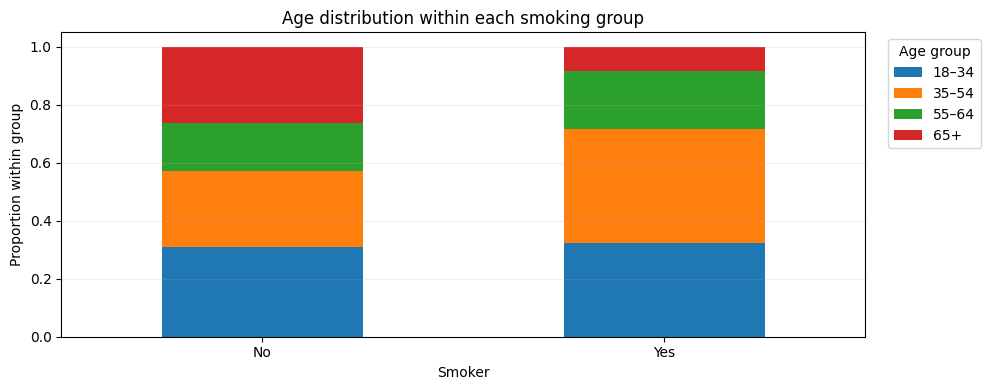

In [31]:
age_dist = pd.crosstab(df["Smoker"], df["age_group"], normalize="index")

ax = age_dist.plot(kind="bar", stacked=True, figsize=(10,4))
ax.set_title("Age distribution within each smoking group")
ax.set_xlabel("Smoker")
ax.set_ylabel("Proportion within group")
ax.grid(True, axis="y", alpha=0.2)
plt.xticks(rotation=0)
plt.legend(title="Age group", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

This confirms that previously smokers appeared to have a lower mortality because the age distributions differ: **smokers are much less represented in the 65+ group** (≈8.4% vs ≈26.4% for non-smokers), and mortality is very high at older ages.

## Part C: Logistic regression

To avoid bias from arbitrary age bins, we model the probability of death over 20 years using logistic regression. We fit a model with Age and smoking status to estimate the effect of smoking on mortality while adjusting for age: **Death ~ Age + Smoker**.

In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf 
from patsy import dmatrix

df["death"] = (df["Status"].str.strip().str.title() == "Dead").astype(int)
df["smoker"] = (df["Smoker"].str.strip().str.title() == "Yes").astype(int)

model = smf.logit("death ~ Age + smoker", data=df).fit(disp=False)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.3579
Time:                        22:50:52   Log-Likelihood:                -500.95
converged:                       True   LL-Null:                       -780.16
Covariance Type:            nonrobust   LLR p-value:                5.534e-122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3519      0.360    -17.637      0.000      -7.058      -5.646
Age            0.0998      0.006     17.290      0.000       0.089       0.111
smoker         0.2787      0.165      1.689      0.0

We also visualize a logistic fit of death vs age separately for smokers and non-smokers to illustrate the relationship.

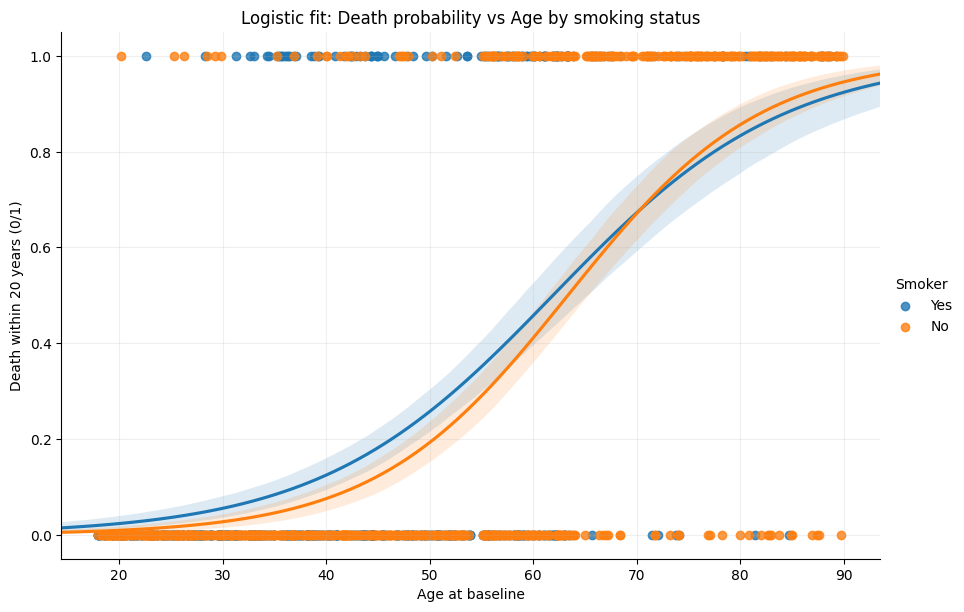

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    x="Age", y="death", hue="Smoker", data=df,
    logistic=True, truncate=False,
    height=6, aspect=1.5,
    ci=95
)

plt.title("Logistic fit: Death probability vs Age by smoking status")
plt.xlabel("Age at baseline")
plt.ylabel("Death within 20 years (0/1)")
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.2)
plt.show()

Age strongly increases mortality risk, and once age is accounted for, the smoking effect is weaker and not clearly significant in this model, suggesting the paradox is largely explained by differences in age distribution between smokers and non-smokers.

## Conclusion
This notebook shows Simpson’s paradox in the Whickham data: overall mortality rate is lower for smokers than for non-smokers. The mismatch is due to age acting as a confounder and different age distributions across groups. Logistic regression confirms that age is the main predictor of death probability and provides a comparison between smokers and non-smokers after adjustment.